# `OOD Detection applied to SST2 and IMDB`


In [4]:

import pandas as pd 
import numpy as np 

from tqdm import tqdm
import datasets
from datasets import load_dataset

import pandas as pd 
import numpy as np 

from tqdm import tqdm
from typing import List, Dict


from itertools import chain

import matplotlib.pyplot as plt 
from matplotlib.axes import Axes
import seaborn as sns

import pickle as pkl 
import json

from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve, 
    auc
) 


from transformers import AutoConfig, BertForSequenceClassification

import torch 
from torch import Tensor


from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)


from toddbenchmark.classification_datasets import (
    prep_model, 
    load_sst2, 
)
from toddbenchmark.classification_datasets_configs import (
    DATASETS_CONFIGS,
    load_requested_dataset,
)

from toddbenchmark.utils_classification import (
    prepare_detectors,
    evaluate_dataloader,
)


from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, minmax_scale, MinMaxScaler

#metrics 
from sklearn.metrics import accuracy_score ,balanced_accuracy_score, make_scorer, confusion_matrix, f1_score, classification_report, roc_auc_score


from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)

# `Our models`

This work is based on Bert architectures. 

In [5]:
Models = {"BERT": "echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", "DistilBERT": "distilbert-base-uncased-finetuned-sst-2-english"} 

model, tokenizer = prep_model(Models["BERT"], config={"label": 2})

### **`Datasets`**

**In-DS : SST2**

In [6]:
config_args_sst2 = { "tokenizer": tokenizer, "train_size": 1000, "validation_size": 000, "test_size": 1000, "ood_label" : 0}

train_loader_sst2, val_loader_sst2, test_loader_sst2 = load_requested_dataset(config_name="sst2", **config_args_sst2)


Found cached dataset glue (/Users/joevincentgaltie/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

**Out-DS : IMDB**

In [7]:
config_args_imdb = { "tokenizer": tokenizer, "train_size": 0, "validation_size": 0, "test_size": 1000, "ood_label" : 1}


_, _, test_loader_imdb = load_requested_dataset(config_name="imdb", **config_args_imdb)

Found cached dataset imdb (/Users/joevincentgaltie/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
next(iter(test_loader_imdb))

{'text': ['I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as

In [9]:
sum(batch["labels"].shape[0] for batch in test_loader_imdb)

1000

 **very OOD dataset**

In [10]:
config_args_imdb = { "tokenizer": tokenizer, "train_size": 0, "validation_size": 0, "test_size": 1000, "ood_label" : 1}


_, _, test_loader_rte = load_requested_dataset(config_name="rte", **config_args_imdb)

Found cached dataset glue (/Users/joevincentgaltie/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
print(next(iter(train_loader_sst2)))
print("")
print(next(iter(test_loader_imdb)))
print("")
print(next(iter(test_loader_rte)))
print("")

{'text': ['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature ', 'remains utterly satisfied to remain the same throughout ', 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', "that 's far too tragic to merit such superficial treatment ", 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'of saucy ', "a depressed fifteen-year-old 's suicidal poetry ", "are more deeply thought through than in most ` right-thinking ' films ", 'goes to absurd lengths ', "for those moviegoers who complain that ` they do n't make movies like they used to anymore ", "the part where nothing 's happening , ", 'saw how bad this movie was ', 'lend some dignity to a dumb story ', 'the greatest musicians '], 'labels': tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,

-------
-------
-------


### `Very simplistic supervised approach`

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(train_loader_sst2):

        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]  #First_token
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)   # 

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)


100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


In [13]:
hidden_in = hidden_states

In [14]:
mean_embeddings_in_ds = mean_embeddings


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
# model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(test_loader_imdb):
        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)

  0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 63/63 [07:45<00:00,  7.40s/it]


In [16]:
mean_embeddings_out_ds = mean_embeddings

In [17]:
hidden_out = hidden_states

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
# model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(test_loader_rte):
        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)

mean_embeddings_very_out_ds = mean_embeddings

  0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


In [19]:
hidden_very_out = hidden_states

In [20]:
mean_embeddings_out_ds.mean(axis=0).mean(axis=-1)
mean_embeddings_in_ds.mean(axis=0).mean(axis=-1)

tensor(-0.0084)

In [21]:
mean_embeddings_in_ds.size()

torch.Size([1000, 768])

In [22]:
tensor0 = mean_embeddings_in_ds
tensor1 = mean_embeddings_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))


In [23]:
data.shape

(2000, 769)

In [24]:
#data[:,:-1]
data[:,-1]

array([0., 0., 0., ..., 1., 1., 1.])

In [25]:
x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)

In [26]:
import collections
collections.Counter(y_test)

Counter({1.0: 198, 0.0: 202})

In [27]:
pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb_clf.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'XGB__max_depth': [1, 2, 3, 4],
                         'XGB__n_estimators': [200, 300, 400, 500]},
             scoring='f1')

In [28]:
xgb_clf.predict(x_test)

array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,

In [29]:
print('Returned hyperparameter: {}'.format(xgb_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb_clf.predict(x_test),y_test)))

Returned hyperparameter: {'XGB__max_depth': 1, 'XGB__n_estimators': 200}
Best classification accuracy in train is: 1.0
Classification accuracy on test is: 1.0


In [30]:
print(xgb_clf.best_params_)

print(f1_score(xgb_clf.predict(x_test),y_test))

print(confusion_matrix(xgb_clf.predict(x_test),y_test))

print(classification_report(xgb_clf.predict(x_test),y_test))

{'XGB__max_depth': 1, 'XGB__n_estimators': 200}
1.0
[[202   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       1.00      1.00      1.00       198

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [31]:
x_test[:,135]

array([ 0.18288314,  0.26368925, -0.17942682, -0.3542898 ,  0.3656221 ,
        0.19122565, -0.28605139,  0.40432078, -0.29804906, -0.33987403,
        0.24951801,  0.23973089,  0.27645516, -0.27849421, -0.31286031,
       -0.21596766,  0.25856236, -0.2881664 , -0.33850282, -0.28372782,
       -0.32994539, -0.49246404,  0.17477095,  0.18539244,  0.13312092,
       -0.17873549, -0.28274322, -0.23530425, -0.22706394, -0.2484647 ,
        0.18437532,  0.22065547,  0.35426414,  0.12220779, -0.3385855 ,
        0.359375  ,  0.27046978,  0.28475833, -0.28648323,  0.366117  ,
       -0.33746591,  0.16706246,  0.17092395,  0.22185194, -0.19751328,
       -0.31393564, -0.1583935 ,  0.38901806,  0.17519534,  0.15565214,
        0.23309058, -0.1833252 , -0.24239781, -0.30796376,  0.02023083,
       -0.27396125, -0.41096354,  0.31199041, -0.23519966,  0.292813  ,
        0.24501041,  0.24993467, -0.3562403 ,  0.27133599,  0.50981742,
       -0.39926568,  0.13692346, -0.34710905,  0.32686001, -0.23

In [32]:
print(np.argwhere(xgb_clf.best_estimator_[0].feature_importances_>0))
xgb_clf.best_estimator_[0].feature_importances_[np.argwhere(xgb_clf.best_estimator_[0].feature_importances_>0)] ##the 135th is dominant...


[[135]]


array([[1.]], dtype=float32)

In [33]:
tensor0 = mean_embeddings_in_ds
tensor1 = mean_embeddings_very_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))

x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)


pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb2_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb2_clf.fit(x_train, y_train)


print('Returned hyperparameter: {}'.format(xgb2_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb2_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb2_clf.predict(x_test),y_test)))

Returned hyperparameter: {'XGB__max_depth': 2, 'XGB__n_estimators': 200}
Best classification accuracy in train is: 0.9912593203707524
Classification accuracy on test is: 0.9924433249370276


In [34]:
print(xgb2_clf.best_params_)

print(f1_score(xgb2_clf.predict(x_test),y_test))

print(confusion_matrix(xgb2_clf.predict(x_test),y_test))

print(classification_report(xgb2_clf.predict(x_test),y_test))

{'XGB__max_depth': 2, 'XGB__n_estimators': 200}
0.9924433249370276
[[200   2]
 [  1 197]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       202
           1       0.99      0.99      0.99       198

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [35]:
print(np.argwhere(xgb2_clf.best_estimator_[0].feature_importances_>0))
xgb2_clf.best_estimator_[0].feature_importances_[np.argwhere(xgb2_clf.best_estimator_[0].feature_importances_>0)]

[[ 10]
 [ 63]
 [ 65]
 [ 79]
 [101]
 [110]
 [135]
 [136]
 [145]
 [164]
 [171]
 [180]
 [188]
 [191]
 [200]
 [223]
 [259]
 [276]
 [318]
 [324]
 [340]
 [343]
 [355]
 [356]
 [370]
 [402]
 [404]
 [411]
 [421]
 [422]
 [432]
 [458]
 [474]
 [481]
 [484]
 [490]
 [492]
 [498]
 [539]
 [558]
 [565]
 [576]
 [593]
 [600]
 [606]
 [611]
 [617]
 [626]
 [648]
 [649]
 [654]
 [656]
 [658]
 [672]
 [681]
 [688]
 [716]
 [721]
 [732]
 [746]
 [752]
 [766]
 [767]]


array([[2.45550275e-02],
       [1.10474345e-03],
       [3.08263139e-03],
       [5.49880322e-03],
       [1.30967272e-03],
       [1.12454516e-04],
       [5.24483144e-01],
       [2.52688350e-03],
       [6.28326880e-03],
       [1.11415638e-02],
       [9.35583957e-04],
       [4.73485142e-03],
       [1.44124478e-02],
       [1.92519592e-03],
       [6.43648999e-03],
       [7.99544528e-03],
       [7.03001686e-04],
       [2.29129451e-04],
       [7.54774257e-04],
       [7.03249872e-03],
       [4.11101570e-03],
       [3.99885757e-04],
       [1.09325175e-03],
       [6.95550907e-03],
       [1.40537880e-02],
       [1.01485068e-03],
       [1.07556311e-02],
       [2.13005138e-03],
       [2.74781458e-04],
       [4.71297448e-04],
       [7.74135664e-02],
       [3.27921435e-02],
       [2.71510240e-02],
       [7.71237537e-03],
       [8.58498039e-04],
       [1.48550328e-03],
       [1.82326548e-02],
       [1.17294779e-02],
       [2.17864188e-04],
       [1.94561835e-02],


**Diagnostic** : **why does xgboost seem to work too perfectly hence not to work**

In [36]:
for i in range(13) : 
    print(f'la couche {i} pour le in-ds renvoie la colonne 135 suivante: {hidden_in[i][:, 0, :][:,135]}')
    print(f'la couche {i} pour le out-ds renvoie la colonne 135 suivante: {hidden_out[i][:, 0, :][:,135]}')
    print(f'la couche {i} pour le very-out-ds renvoie la colonne 135 suivante: {hidden_very_out[i][:, 0, :][:,135]}')
    print("")

la couche 0 pour le in-ds renvoie la colonne 135 suivante: tensor([0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658])
la couche 0 pour le out-ds renvoie la colonne 135 suivante: tensor([0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658])
la couche 0 pour le very-out-ds renvoie la colonne 135 suivante: tensor([0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658])

la couche 1 pour le in-ds renvoie la colonne 135 suivante: tensor([0.1372, 0.1235, 0.1655, 0.1501, 0.1680, 0.1489, 0.1351, 0.1134])
la couche 1 pour le out-ds renvoie la colonne 135 suivante: tensor([0.1822, 0.1857, 0.1835, 0.1790, 0.1675, 0.1579, 0.1446, 0.1469])
la couche 1 pour le very-out-ds renvoie la colonne 135 suivante: tensor([0.1641, 0.1786, 0.1501, 0.1657, 0.1480, 0.1457, 0.1992, 0.1961])

la couche 2 pour le in-ds renvoie la colonne 135 suivante: tensor([0.0740, 0.0362, 0.0692, 0.0864, 0.1098, 0.0814, 0.0415, 0.0278])
la couche 2 pour le out-ds renvoie la colonne 135 suivante: 

In [37]:
dict= {}
for ele in [hidden_in,hidden_out,hidden_very_out]:
    for i in range(13):
            embedding_batch=[]
            layer_embeddings = ele[i][:, 0, :]
            embedding_batch.append(layer_embeddings)

    embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)
    dict[ele] = embedding_batch_mean

In [38]:
print(mean_embeddings_in_ds[:,135])
print(mean_embeddings_out_ds[:,135])
print(mean_embeddings_very_out_ds[:,135])

tensor([-0.3412, -0.4021, -0.3867, -0.3781, -0.2866, -0.3663, -0.3331, -0.2982,
        -0.3121, -0.3694, -0.3515, -0.1330, -0.3410, -0.3095, -0.4179, -0.2480,
        -0.3521, -0.3297, -0.4015, -0.3073, -0.2941, -0.2507, -0.2980, -0.2425,
        -0.3627, -0.2705, -0.4973, -0.2618, -0.2670, -0.3699, -0.4249, -0.2437,
        -0.3763, -0.3198, -0.2989, -0.3492, -0.5691, -0.2826, -0.3794, -0.2791,
        -0.2585, -0.3381, -0.2636, -0.2987, -0.2804, -0.2825, -0.3374, -0.2528,
        -0.2390, -0.3209, -0.2271, -0.2425, -0.3528, -0.2505, -0.2574, -0.2291,
        -0.2478, -0.3004, -0.2211, -0.3453, -0.2512, -0.3421, -0.2657, -0.2085,
        -0.3114, -0.3198, -0.3851, -0.3807, -0.1133, -0.4123, -0.2398, -0.3656,
        -0.3266, -0.2680, -0.3422, -0.2514, -0.4073, -0.2991, -0.3652, -0.2160,
        -0.2889, -0.2258, -0.2903, -0.2447, -0.2978, -0.1833, -0.2919, -0.3153,
        -0.3073, -0.2956, -0.2584, -0.4265, -0.3126, -0.2463, -0.2814, -0.2865,
        -0.2268, -0.2089, -0.2237, -0.26

In [39]:
tensor0 = mean_embeddings_out_ds
tensor1 = mean_embeddings_very_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))

x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)


pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb3_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb3_clf.fit(x_train, y_train)


print('Returned hyperparameter: {}'.format(xgb3_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb3_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb3_clf.predict(x_test),y_test)))

Returned hyperparameter: {'XGB__max_depth': 1, 'XGB__n_estimators': 200}
Best classification accuracy in train is: 1.0
Classification accuracy on test is: 1.0


In [40]:
print(xgb3_clf.best_params_)

print(f1_score(xgb3_clf.predict(x_test),y_test))

print(confusion_matrix(xgb3_clf.predict(x_test),y_test))

print(classification_report(xgb3_clf.predict(x_test),y_test))

{'XGB__max_depth': 1, 'XGB__n_estimators': 200}
1.0
[[191   0]
 [  0 209]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       209

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



------
------

### `OOD Detection based on distance scorer`

In [41]:
model, tokenizer = prep_model(Models["BERT"], config={"label": 2})

### **Loading and evaluating detectors on our datasets**

In [42]:
detectors: List[ScorerType] = [
    MahalanobisScorer(layers=[l for l in range(1,13)]),
    CosineProjectionScorer(layers=[l for l in range(13)]), 
]


In [43]:
for detector in detectors: 
    print(detector, detector.__dict__)
    print("")

MahalanobisScorer {'score_names': [], 'chosen_state': 'encoder_hidden_states', 'use_first_token_only': True, 'accumulated_embeddings': defaultdict(<class 'list'>, {}), 'layers': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 'accumulation_device': 'cpu', 'covs': None, 'means': None}

CosineProjectionScorer {'score_names': [], 'chosen_state': 'encoder_hidden_states', 'use_first_token_only': True, 'accumulated_embeddings': defaultdict(<class 'list'>, {}), 'layers': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 'accumulation_device': 'cpu', 'reference_embeddings': {}}



In [44]:
detectors = prepare_detectors(detectors, model, train_loader_sst2, tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Fitting detectors...: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


In [45]:
with open("detectors.pkl", "wb") as f: 
    pkl.dump(detectors, f)

In [46]:
print("Evaluating on the sst2 training set : in-ds")

records_in_train = evaluate_dataloader( model, train_loader_sst2, tokenizer, detectors)

print("Evaluating on the sst2 test set : in-ds")

records_in_test = evaluate_dataloader(model, test_loader_sst2, tokenizer, detectors)

print("Evaluating on the imdb test set : out-ds")

records_out_test = evaluate_dataloader(model, test_loader_imdb, tokenizer, detectors)

print("Evaluating on the imdb test set : very-out-ds")

records_very_out_test = evaluate_dataloader(model, test_loader_rte, tokenizer, detectors)

records = {"in_train": records_in_test, "in_test": records_in_train, "out_test" : records_out_test, "very_out_ds" : records_very_out_test}

print("saving..")

with open("records.pkl", "wb") as file: 
    pkl.dump(records, file)


Evaluating on the sst2 training set : in-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [02:02<00:00,  1.94s/it]


Evaluating on the sst2 test set : in-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [02:15<00:00,  2.15s/it]


Evaluating on the imdb test set : out-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [12:55<00:00, 12.32s/it]


Evaluating on the imdb test set : very-out-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [02:14<00:00,  2.14s/it]

saving..


In [47]:
records = {"in_train": records_in_test, "in_test": records_in_train, "out_test" : records_out_test, "very_out_ds" : records_very_out_test}

In [48]:
file_path = f"records.pkl"
with open(file_path, "wb") as file: 
    pkl.dump(records, file)
    print(f"File successfully saved at {file_path}.")

File successfully saved at records.pkl.


### **Load**

In [49]:
def average_scorer_per_layer(records: Dict, scorer_name: str):

    values_per_layer = [
        values 
        for key, values in records.items()
        if scorer_name in key
    ]

    return np.mean(values_per_layer, axis=0)



In [50]:
records['in_train'].keys()

dict_keys(['MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_1_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_2_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_3_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_4_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_5_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_6_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_

In [51]:
for ds_type, records_ in records.items(): 

    records[ds_type]["MahalanobisScorerLast"] = records[ds_type]['MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_12_class_0']
    records[ds_type]["CosineProjectionScorerLast"] = records[ds_type]['CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+12_0']

    records[ds_type]["CosineProjectionScorerAvg"] = average_scorer_per_layer(records_, "CosineProjectionScorer")
    records[ds_type]["MahalanobisScorerAvg"] = average_scorer_per_layer(records_, "MahalanobisScorer")



In [52]:
scorers = [ "MahalanobisScorerAvg", "MahalanobisScorerLast", "CosineProjectionScorerAvg","CosineProjectionScorerLast"]
all_scores = { scorer: { record_type: records[record_type][scorer] for record_type in records.keys()} for scorer in scorers}

In [53]:
couleurs = {
    type_ds: col 
    for type_ds, col in zip(["in_train","in_test","out_test","very_out_ds"], sns.color_palette(n_colors=4)) 
}

def distributions_per_scorer(
    scorer: str, 
    records: List, 
    ds_names: List, 
    ax: Axes, 
    density: bool
  ): 
 

    df = pd.DataFrame\
        .from_dict(records, orient="index")\
        .transpose()[ds_names]
    title = scorer


    args = {
        "bins": 100, 
        "palette": [color for type_ds, color in couleurs.items() if type_ds in df.columns]
    }   

    if density: 
        args["stat"] = "density"
        args["kde"] = True

    sns.histplot(data=df, ax=ax, **args)

    ax.set_title(title) 

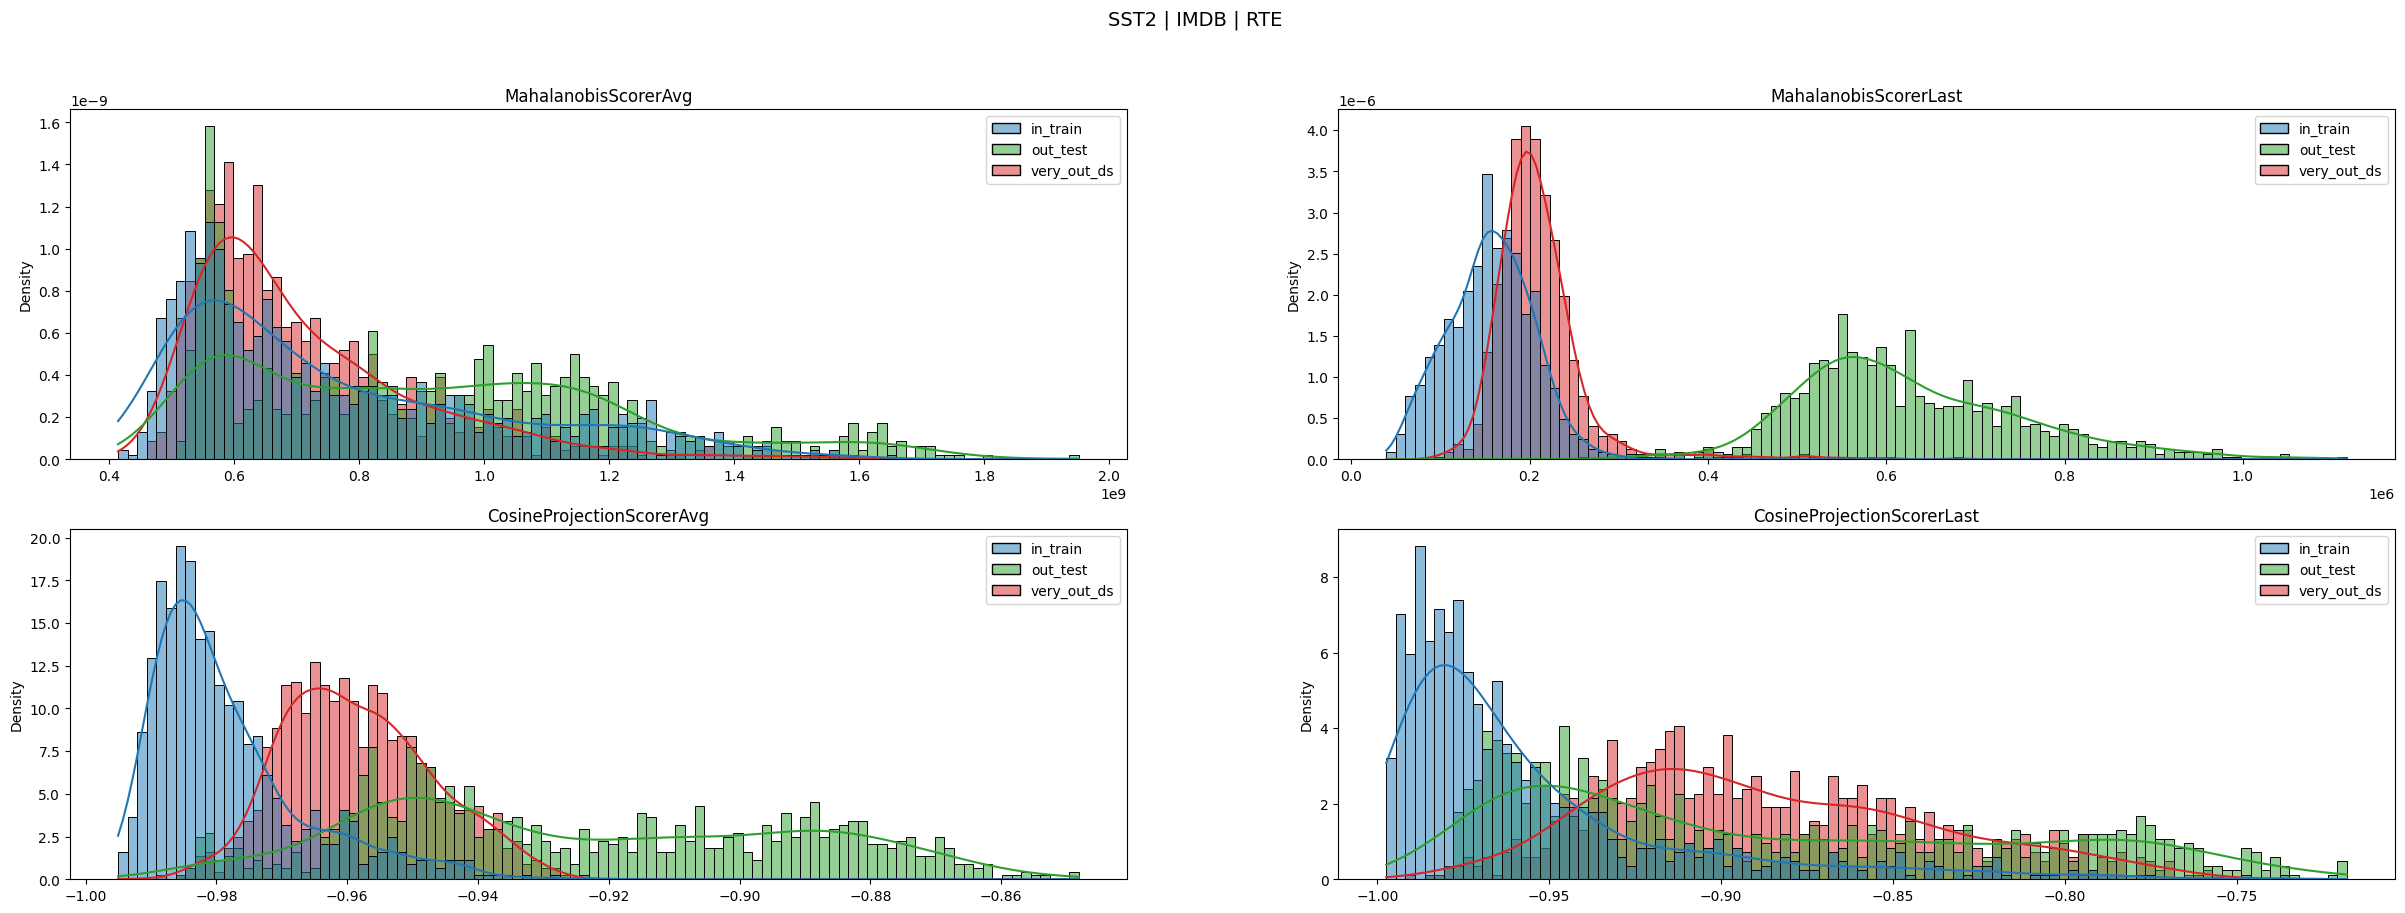

In [54]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30, 10))
fig.suptitle("SST2 | IMDB | RTE", size=14)    

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    distributions_per_scorer(scorer, records, ds_names=["in_train","out_test","very_out_ds"], ax=ax, density=True); 

### **AUROC Curves** 

In [55]:
all_scores['MahalanobisScorerAvg'].keys()

dict_keys(['in_train', 'in_test', 'out_test', 'very_out_ds'])

In [56]:
ood_scoring = { scorer: list(chain(*[ ele for ele in all_scores[scorer].values()])) for scorer in scorers }

is_ood_labels = [0 for i in range(2000)]+ [1 for i in range(2000)]

roc = { scorer: roc_curve(is_ood_labels, ood_scoring[scorer], pos_label=1) for scorer in scorers }


#precision_vs_recall = { scorer: precision_recall_curve(ood_labels, ood_scores[scorer], pos_label=1) for scorer in scorer_names}

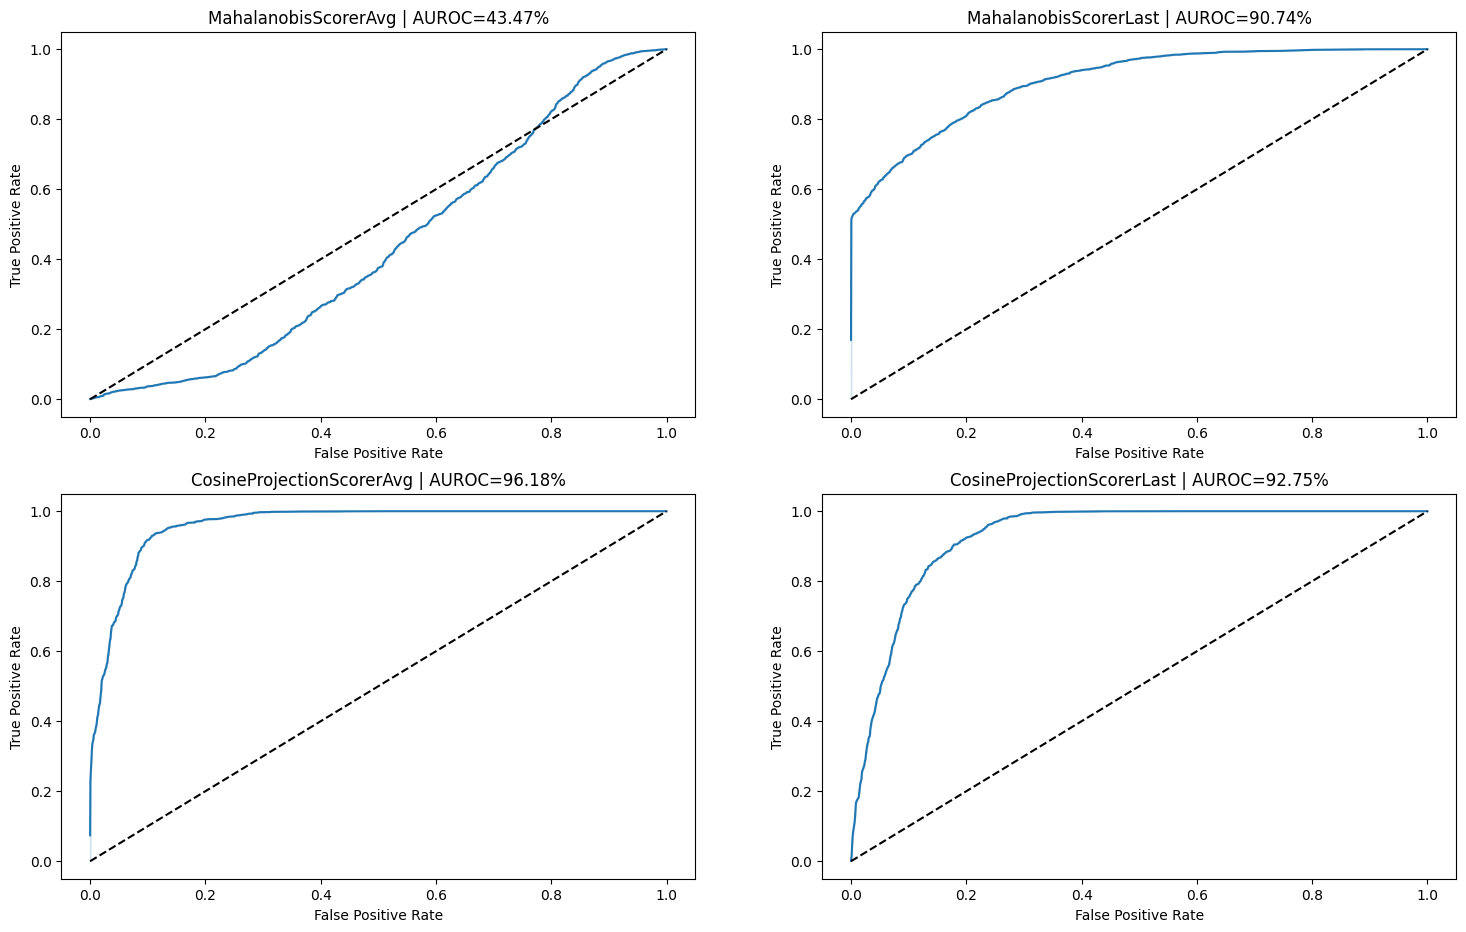

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 11))

for (scorer, (fpr, tpr, _)), ax in zip(roc.items(), axes.flatten()): 
    sns.lineplot(x=fpr, y=tpr, ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", ax=ax, color="black") 

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    auroc = auc(fpr, tpr)
    ax.set_title(f"{scorer} | AUROC={round(100*auroc, 2)}%"); 

**Temporary end**